In [311]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [312]:
from copy import deepcopy, copy
from hdbscan import all_points_membership_vectors, HDBSCAN
from matplotlib.axes import Axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional
from umap import UMAP
from upsetplot import from_memberships, plot, UpSet, from_indicators
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [313]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [314]:
# input and output paths

figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

## FUNCTIONS

In [315]:
# TODO: move these to a module


In [316]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [317]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [318]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

## LOAD DATA

In [320]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-05"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [321]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [322]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

In [323]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

88 features loaded.
77 colours loaded.


## LC+, LC-, HC

### Select which sets of features to use

In [324]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [325]:
# # get the RIO and LUS data, and drop any object columns
# df_rio = df.query("SITE == 4").select_dtypes(exclude = "object")
# df_lus = df.query("SITE == 5").select_dtypes(exclude = "object")
# df_mtl = df.query("SITE == 2").select_dtypes(exclude = "object")
# df_san = df.query("SITE == 3").select_dtypes(exclude = "object")
# df_ldn = df.query("SITE == 1").select_dtypes(exclude = "object")

# df_rio = df_rio.drop(columns = ["SITE", "sex", "age"])
# df_lus = df_lus.drop(columns = ["SITE", "sex", "age"])
# df_mtl = df_mtl.drop(columns = ["SITE", "sex", "age"])
# df_san = df_san.drop(columns = ["SITE", "sex", "age"])
# df_ldn = df_ldn.drop(columns = ["SITE", "sex", "age"])
                                

# # how many na values?
# print(df_rio.isna().sum().sum())
# print(df_lus.isna().sum().sum())

# # drop rows with missing values
# df_rio = df_rio.dropna()
# df_lus = df_lus.dropna()
# df_mtl = df_mtl.dropna()
# df_san = df_san.dropna()
# df_ldn = df_ldn.dropna()


# # cast any booleans to int
# df_rio = df_rio.astype(int)
# df_lus = df_lus.astype(int)
# df_mtl = df_mtl.astype(int)
# df_san = df_san.astype(int)
# df_ldn = df_ldn.astype(int)


# # df_lus has some values > 1; replace them with 1
# df_lus = df_lus.clip(upper = 1)
# df_mtl = df_mtl.clip(upper = 1)



In [326]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_rio.T, ax = ax, cmap = "viridis", cbar = False,)

# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_lus.T, ax = ax, cmap = "viridis", cbar = False,)

# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(df_mtl.T, ax = ax, cmap = "viridis", cbar = False,)


In [327]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [328]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [329]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [330]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 28
VAX 1
HHX 54
IMG 9
LAB 47
SUBS 5


# CLUSTERING

In [331]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [332]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [333]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms

In [334]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

### Handling missing values

In [340]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

print(X.shape)

(2189, 245)


In [341]:
LC_pos_.shape

(2194, 246)

In [348]:
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

### EMBED and CLUSTER

In [349]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
# points   = pipe["embed"].embedding_
# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels


# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
# plot_df["Cluster"]            = [c+1 for c in clusters]
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"]               = sites

plot_df, cluster_labels = make_plot_df(pipe, 
                                        sites,
                                        site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(random_state=42, verbose=True)
Tue May 21 10:02:26 2024 Construct fuzzy simplicial set
Tue May 21 10:02:27 2024 Finding Nearest Neighbors
Tue May 21 10:02:27 2024 Finished Nearest Neighbor Search
Tue May 21 10:02:27 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue May 21 10:02:30 2024 Finished embedding


In [350]:
plot_df

x          y  Cluster  Cluster Confidence Site
0     10.886827  10.060935        4            0.921789  MTL
1      9.617863  11.725508        5            1.000000  MTL
2     11.869226  12.628811        5            0.000000  MTL
3      8.947426  11.094581        6            0.973296  MTL
4     11.997931  10.542110        4            0.982885  MTL
...         ...        ...      ...                 ...  ...
5659  11.894533   9.387194        4            0.981963  SAN
5660   9.636382   8.898794        7            0.000000  SAN
5661  12.070279   9.568502        4            0.995342  SAN
5662  11.912281  11.196840        5            0.863156  SAN
5663   8.858782   8.676079        7            0.000000  SAN

[2189 rows x 5 columns]

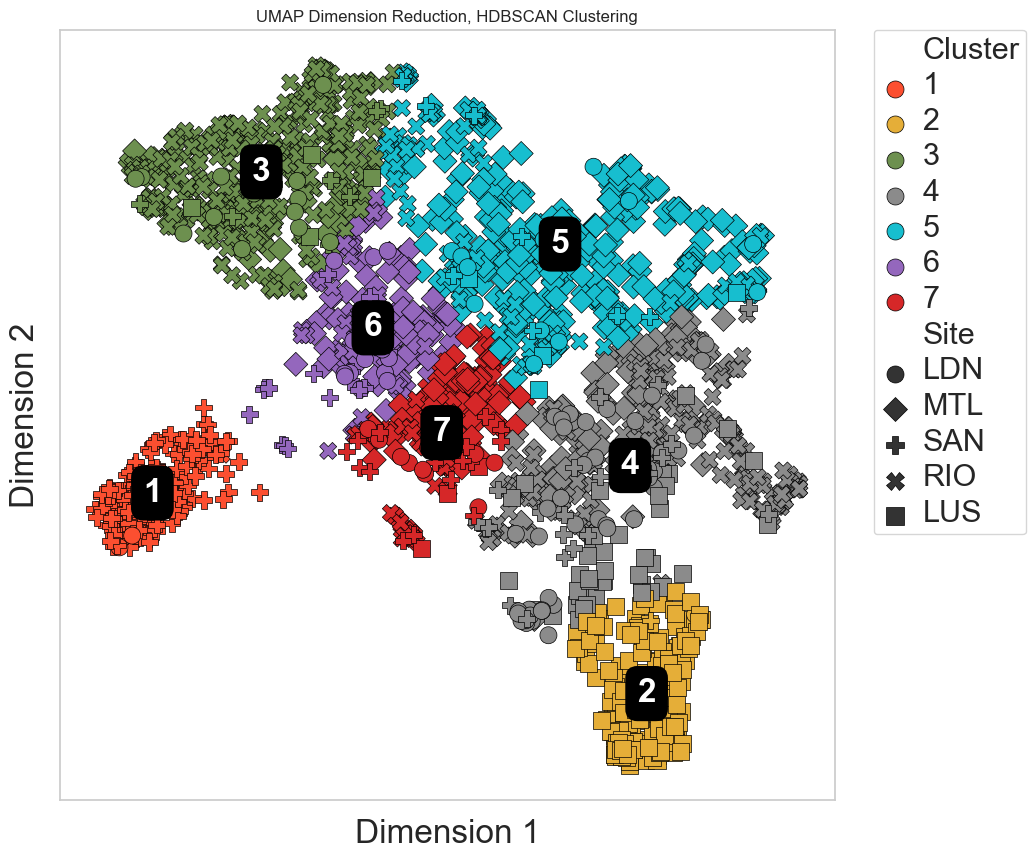

In [351]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [352]:
# 2024-05-06
# redundant: recoded the erroneous records (21 MTL patients) to patient_type 99 to remove from the LC_pos and LC_neg datasets

# # find the indices of the points that x < 4
# idx = plot_df.query("x < 4").index
# idx

# # # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# # # record_ids

# # # get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# # # sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# # # sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

#### Cluster by Site

In [353]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0


#### RFC Model to identify features that differentiate clusters

In [354]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	37
Tentative: 	0
Rejected: 	208


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=124,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x15B882A40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x15B882A40,
         verbose=1)

In [355]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=124, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x15B882A40)

In [357]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


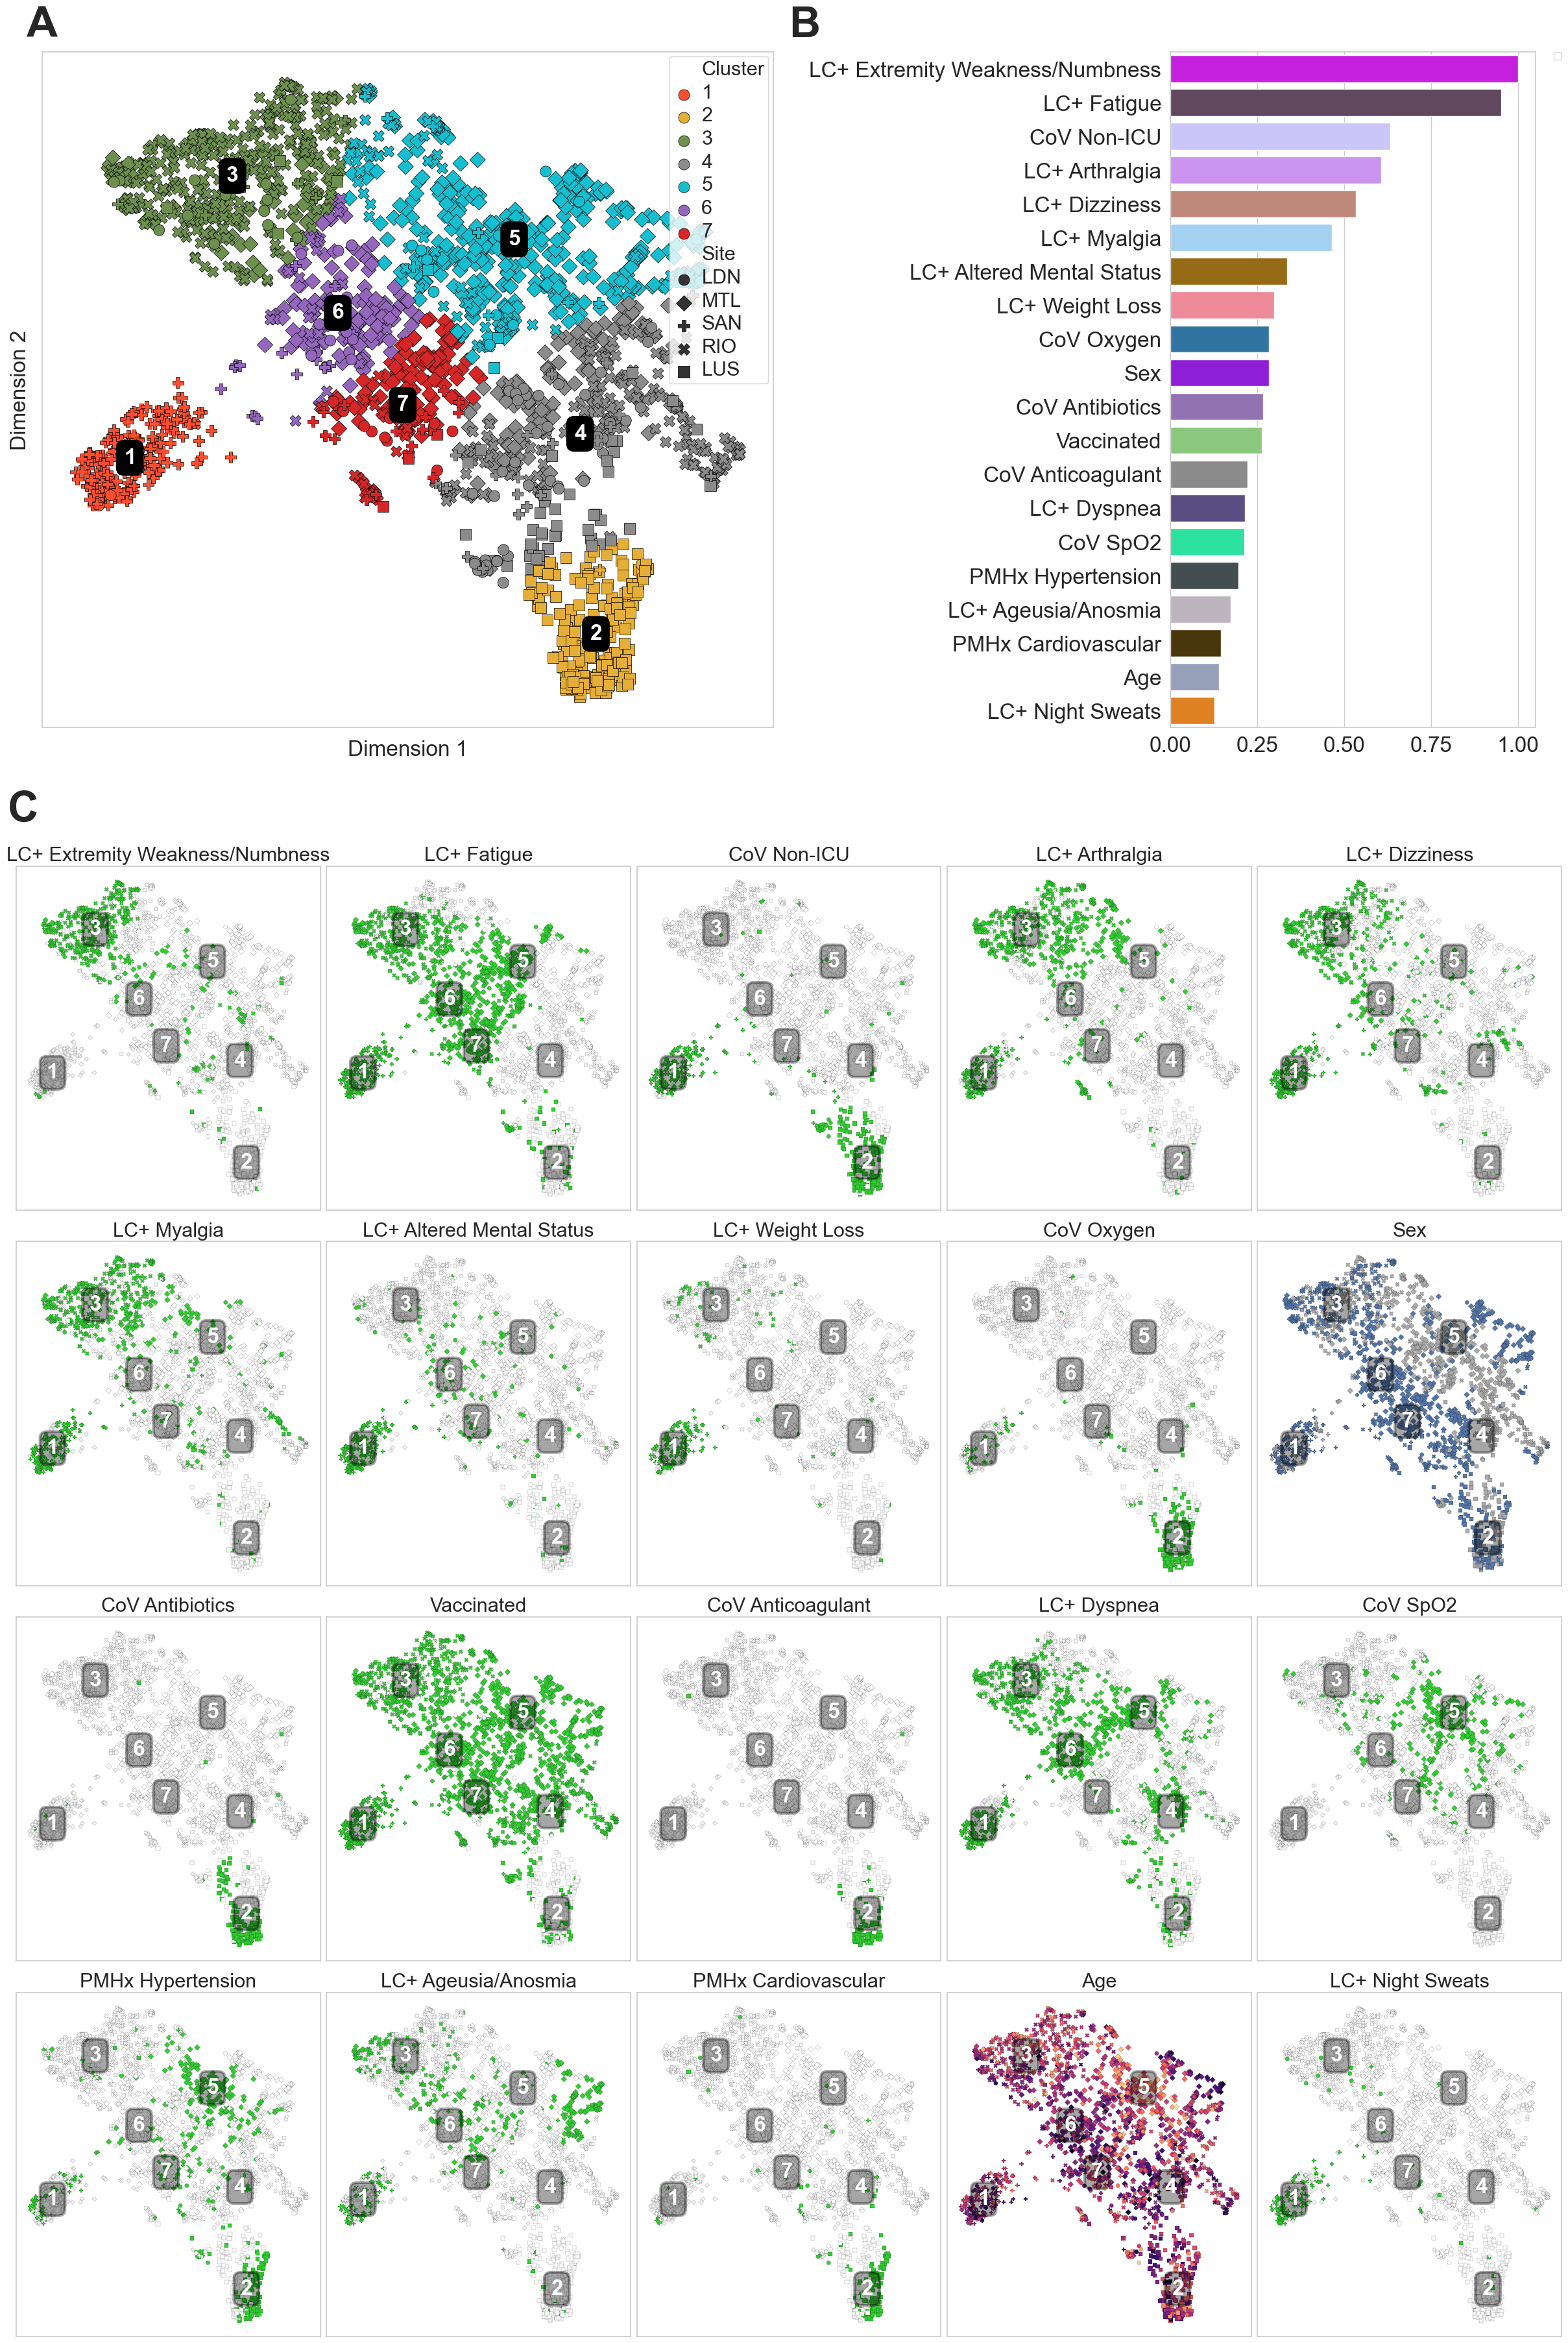

In [358]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = False

if SAVE:
    plt.savefig(f"{figdir}/feature-importances.png", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances.jpg", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [359]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [360]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [361]:
cluster_by_site

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    1.0   14.0   53.0   12.0   17.0   11.0
MTL        0.0    0.0   75.0  164.0  399.0  130.0  127.0
SAN      191.0    1.0    8.0   22.0    9.0   16.0   19.0
RIO        1.0    0.0  335.0  182.0   79.0   26.0   27.0
LUS        0.0  213.0    4.0   44.0    4.0    0.0    3.0

In [362]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

cbsm

cluster            1     2     3     4     5     6     7
Site                                                    
London           1.8   0.9  12.7  48.2  10.9  15.5  10.0
Montreal         0.0   0.0   8.4  18.3  44.6  14.5  14.2
San Diego       71.8   0.4   3.0   8.3   3.4   6.0   7.1
Rio de Janeiro   0.2   0.0  51.5  28.0  12.2   4.0   4.2
Lusaka           0.0  79.5   1.5  16.4   1.5   0.0   1.1

In [363]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

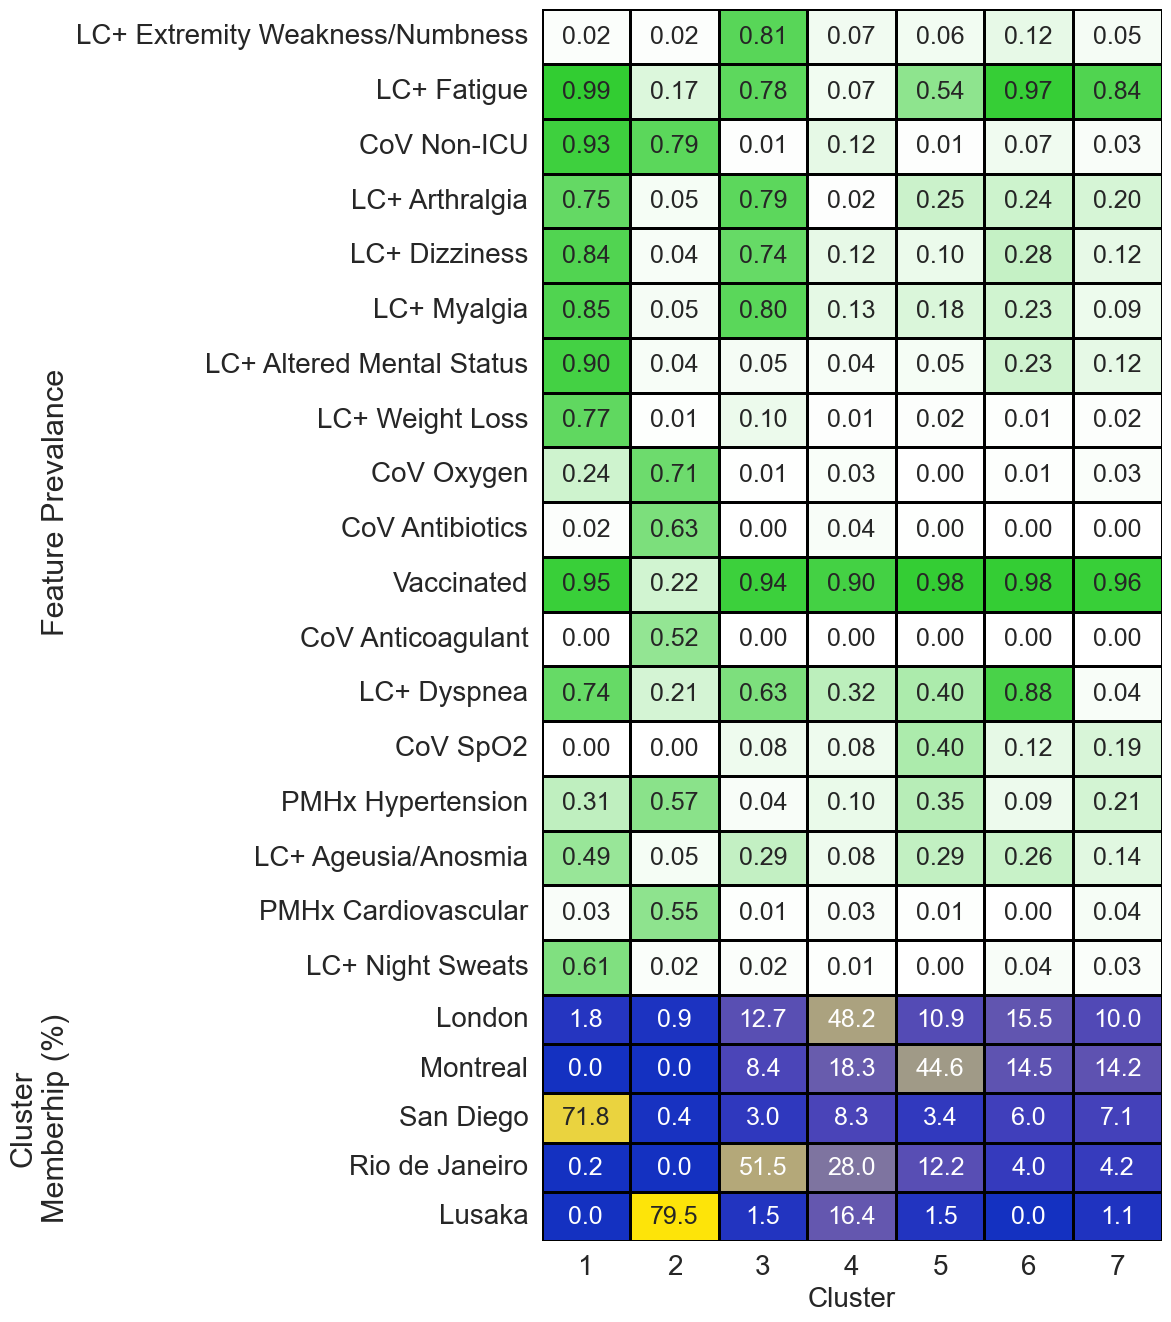

In [364]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/feature-prevalence-by-cluster.png", dpi = 600, bbox_inches = 'tight')


### UPSET PLOTS

In [365]:
# A["SITE"] = LC_pos_["SITE"]
# II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# # get column names and index names from X 
# II.columns = X.columns
# II.index   = X.index


# # A.shape, X.shape, II.shape
# # vv = A.drop("cluster", axis = 1)
# B = II.copy()

# # augment with site labels
# B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# interesting = list(fff["Feature"][:5])
# upset_A = make_upset_data(A, 
#                        interesting, 
#                        )

# upset_data = make_upset_data(B, 
#                                 interesting, 
#                                 keep_features = True
#                                 )

# indicators_bool = upset_data.select_dtypes(include = ['bool'])
# us = UpSet(
#     from_indicators(indicators_bool, data = upset_data),
#     min_subset_size=15,
#     # max_subset_size=200,
#     show_counts                = True,
#     sort_categories_by         = "-input",
#     subset_size                = "count",
#     intersection_plot_elements = 0,
#     orientation                = "horizontal",
# )

# # us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

# us.add_stacked_bars(by="SITE", 
#                        title="Count SITE", 
#                        elements=10, 
#                        colors = cc.m_glasbey_hv, 
#                        )

# us.plot()
# plt.show()

In [366]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

In [367]:
# from scipy.stats import chi2_contingency

# rd = {}

# for site1 in site_name_dict.values():

#     for site2 in site_name_dict.values():

#         for col in X.columns:

#             # get the index of rows where SITE is site1 or site2
#             idx = LC_pos_["SITE"].isin([site1, site2])

#             print(idx)

#             ct = pd.crosstab(LC_pos_.loc[idx]["SITE"], X.loc[idx][col]).rename(index = site_name_dict)


#             print(ct)

#             result = chi2_contingency(ct)
#             if result[1] < 0.05:
#                 # print(ct)
#                 print(f"{site}: \t{col} --> p = {result[1]}")
#                 rd.update({site: result[1]})


# # for col in X.columns:


# #     ct = pd.crosstab(LC_pos_["SITE"], X[col]).rename(index = site_name_dict)

# #     result = chi2_contingency(ct)
# #     if result[1] < 0.05:
# #         # print(ct)
# #         # print(f"{col}: p = {result[1]}")
# #         rd.update({col: result[1]})

# # # make dataframe from rd
# # rd_df = pd.DataFrame.from_dict(rd, orient = "index", columns = ["p-value"])

# # # sort by p-value
# # rd_df.sort_values(by = "p-value", inplace = True, ascending = False)
# # rd_df

# By SITE for subphenotypes at each site

In [368]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS
LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

In [370]:
# cluster pipeline, iterating over the sites

result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    # print(i, k, v)

    print(f"Site {k}: {v}")

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE == {k}").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 0)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    # get the plot dataframe and cluster labels
    sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
Data shape = (110, 245)
X shape    = (110, 244)
Cluster
2    43.636364
3    34.545455
1    21.818182
Name: proportion, dtype: float64
Site 2: MTL
Data shape = (895, 245)
X shape    = (895, 244)
Cluster
5    23.240223
2    22.458101
6    21.564246
4    12.849162
3    10.167598
1     9.720670
Name: proportion, dtype: float64
Site 3: SAN
Data shape = (266, 245)
X shape    = (266, 244)
Cluster
3    42.857143
1    40.225564
2    16.917293
Name: proportion, dtype: float64
Site 4: RIO
Data shape = (651, 245)
X shape    = (650, 244)
Cluster
4    20.615385
6    19.846154
2    19.692308
1    16.461538
3    12.307692
5    11.076923
Name: proportion, dtype: float64
Site 5: LUS
Data shape = (272, 245)
X shape    = (272, 244)
Cluster
1    40.808824
2    22.794118
3    20.220588
4    16.176471
Name: proportion, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


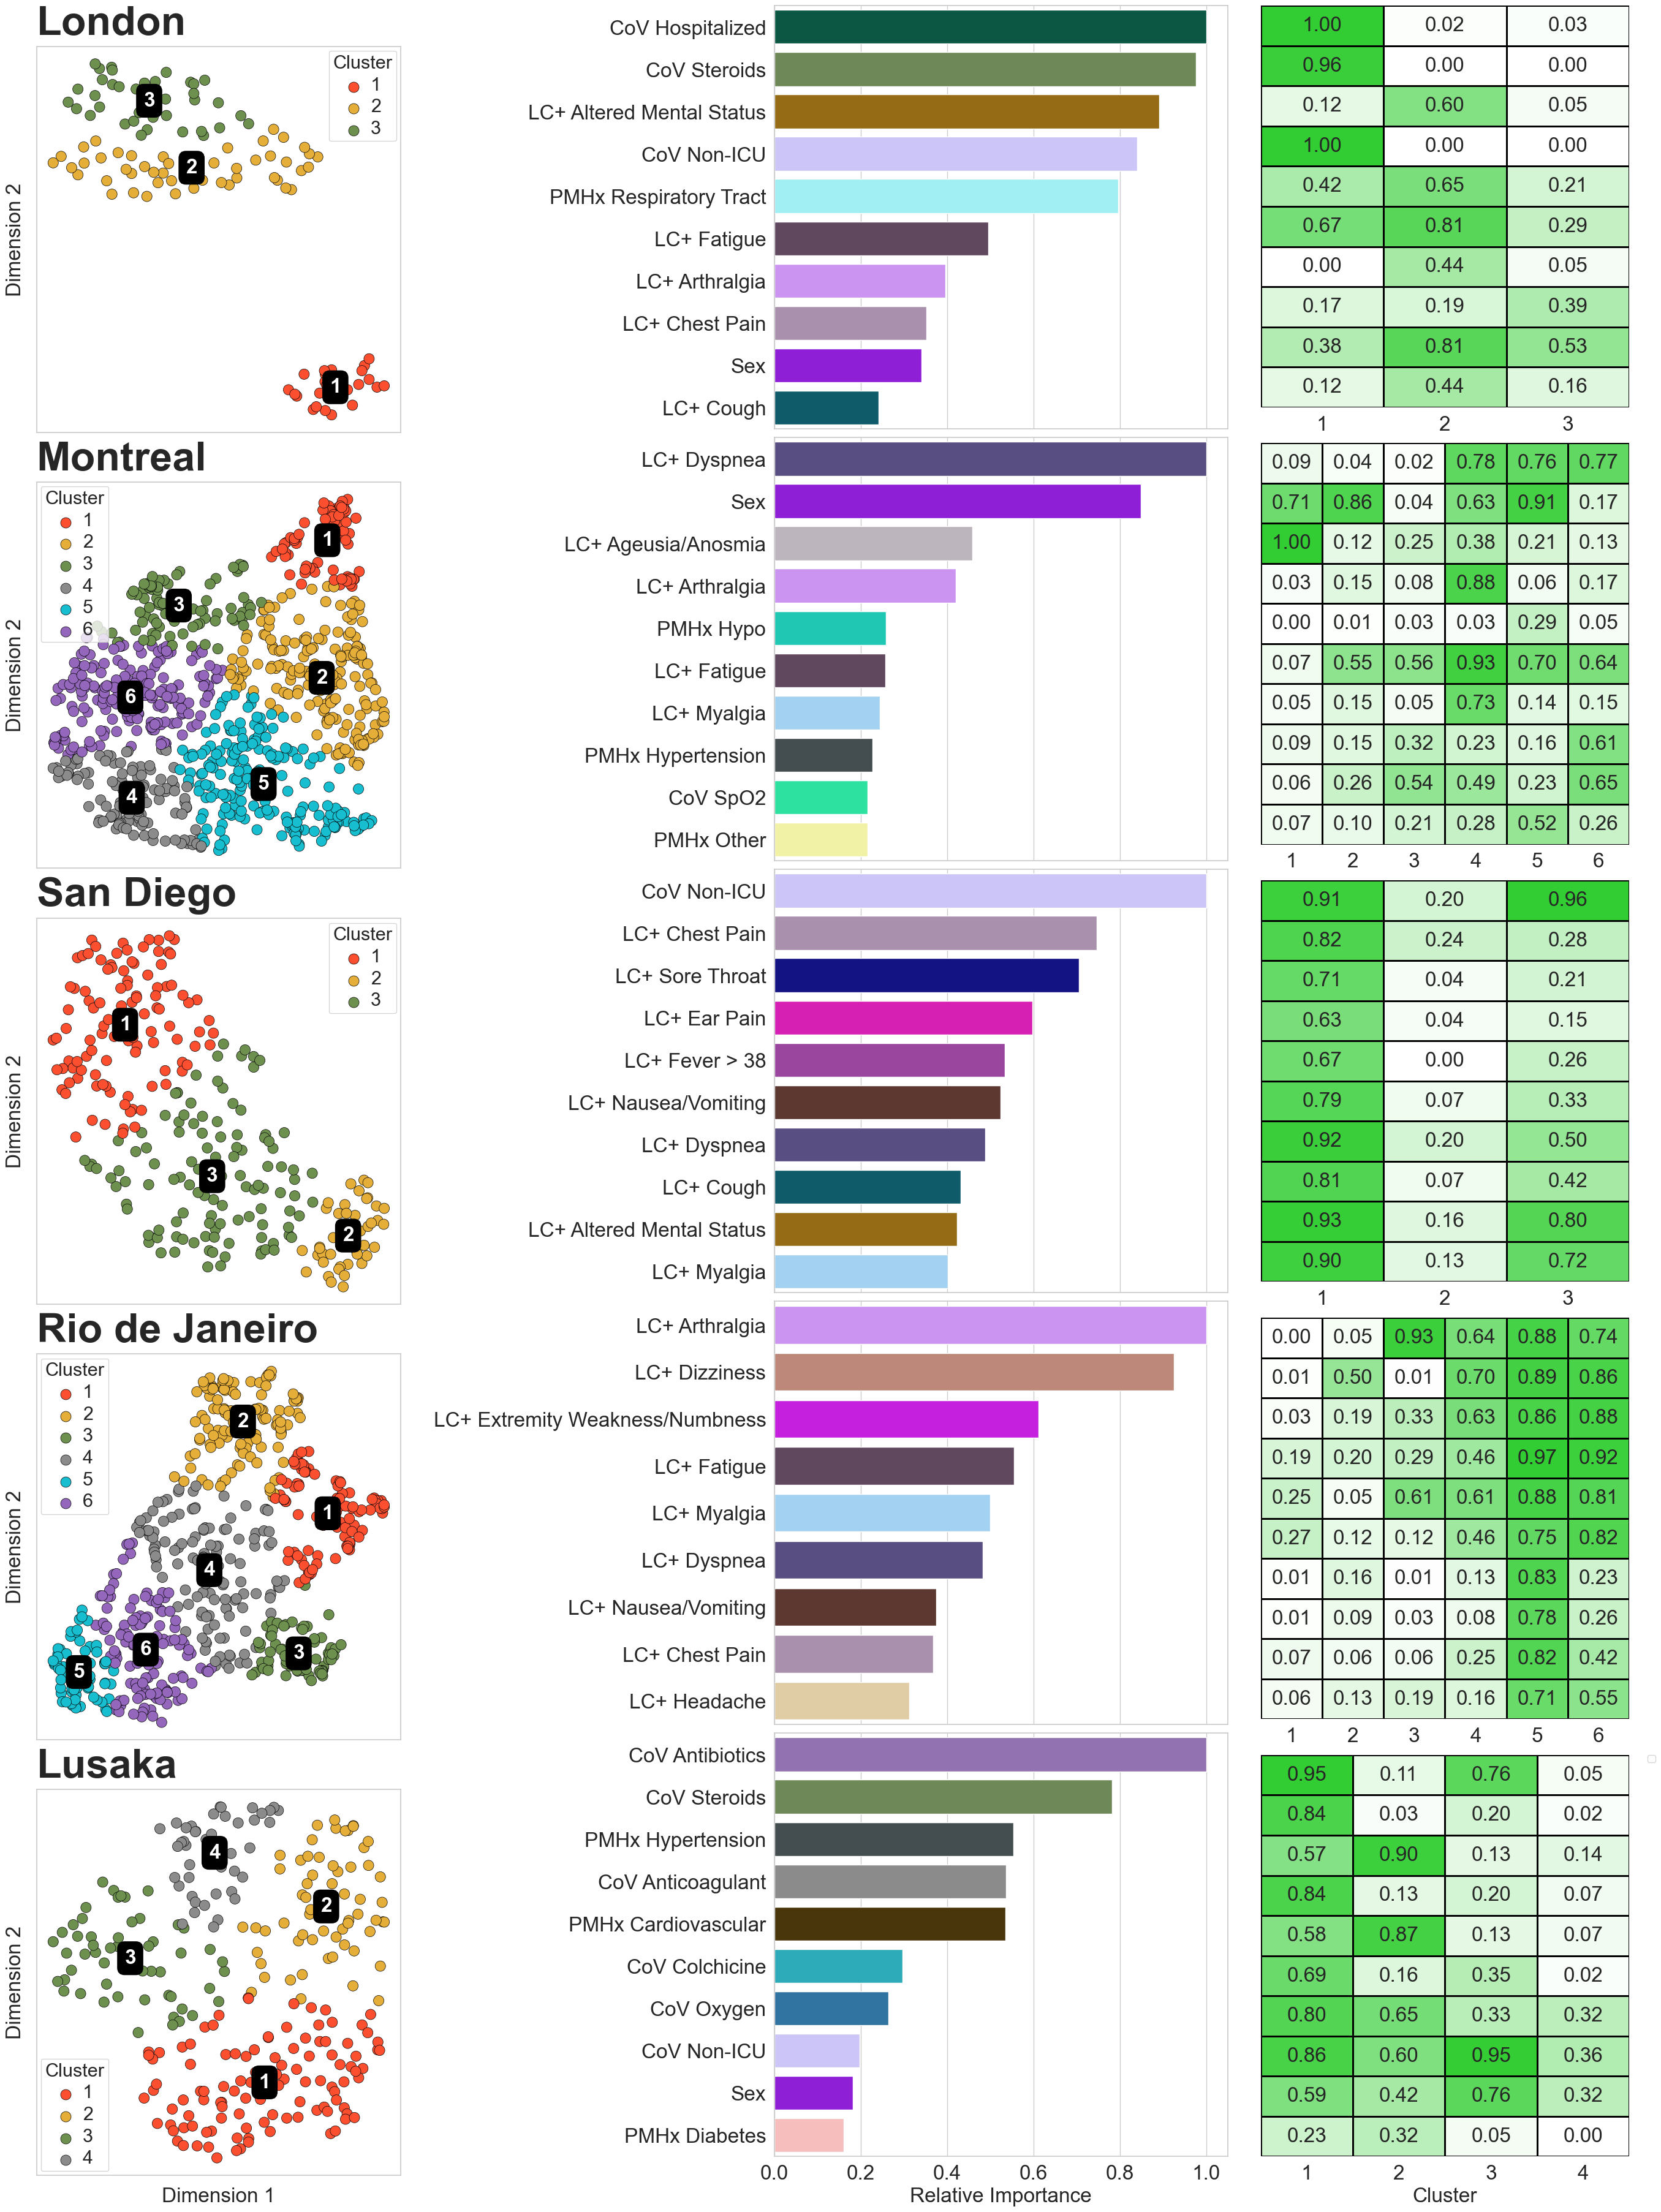

In [371]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = True)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site.png", dpi = 300, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [372]:
# select only the features in new_and_worse
X = LC_pos_[new_and_worse].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(2194, 95)
(2194, 95)
(582, 95)


In [374]:
# cluster pipeline

min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
                # 'min_dist': 0.1,
                # 'metric': 'cosine',
                # 'metric': 'hamming',
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)



UMAP(random_state=42, spread=5.0, verbose=True)
Tue May 21 10:06:14 2024 Construct fuzzy simplicial set
Tue May 21 10:06:14 2024 Finding Nearest Neighbors
Tue May 21 10:06:14 2024 Finished Nearest Neighbor Search
Tue May 21 10:06:14 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue May 21 10:06:16 2024 Finished embedding


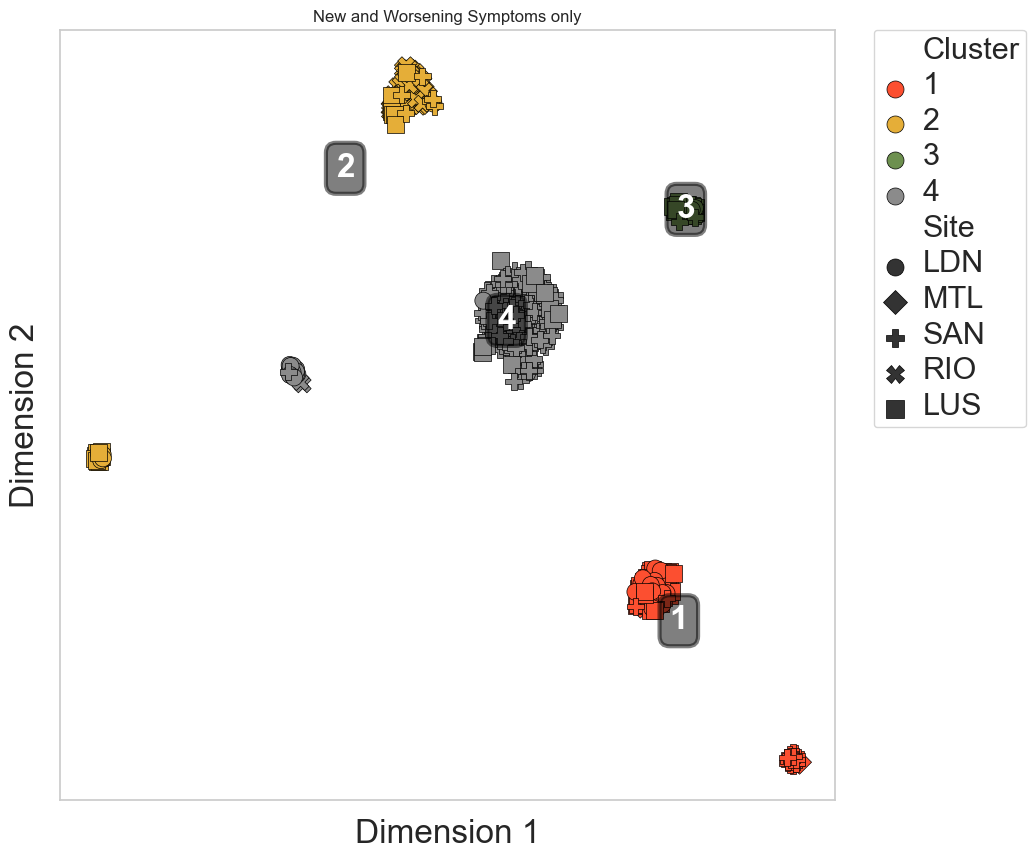

In [375]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = f"New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)


In [376]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# show only 2 decimal places
cluster_by_site = cluster_by_site.round(1)

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster     1     2     3     4
Site                           
LDN      41.3  10.9   4.3  43.5
LUS      34.0   8.4  11.3  46.2
MTL      40.0   0.0   0.0  60.0
RIO       0.0  96.6   0.0   3.4
SAN      11.1   2.6   3.0  83.4


In [377]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	85


RandomForestClassifier(max_depth=7, n_estimators=196, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x31F2EE140)

In [378]:
# dataframes with the feature importance and topN features
fi_df = make_feature_importance_df(clf2, important_features)
features10 = make_topN_features(fi_df, 10, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


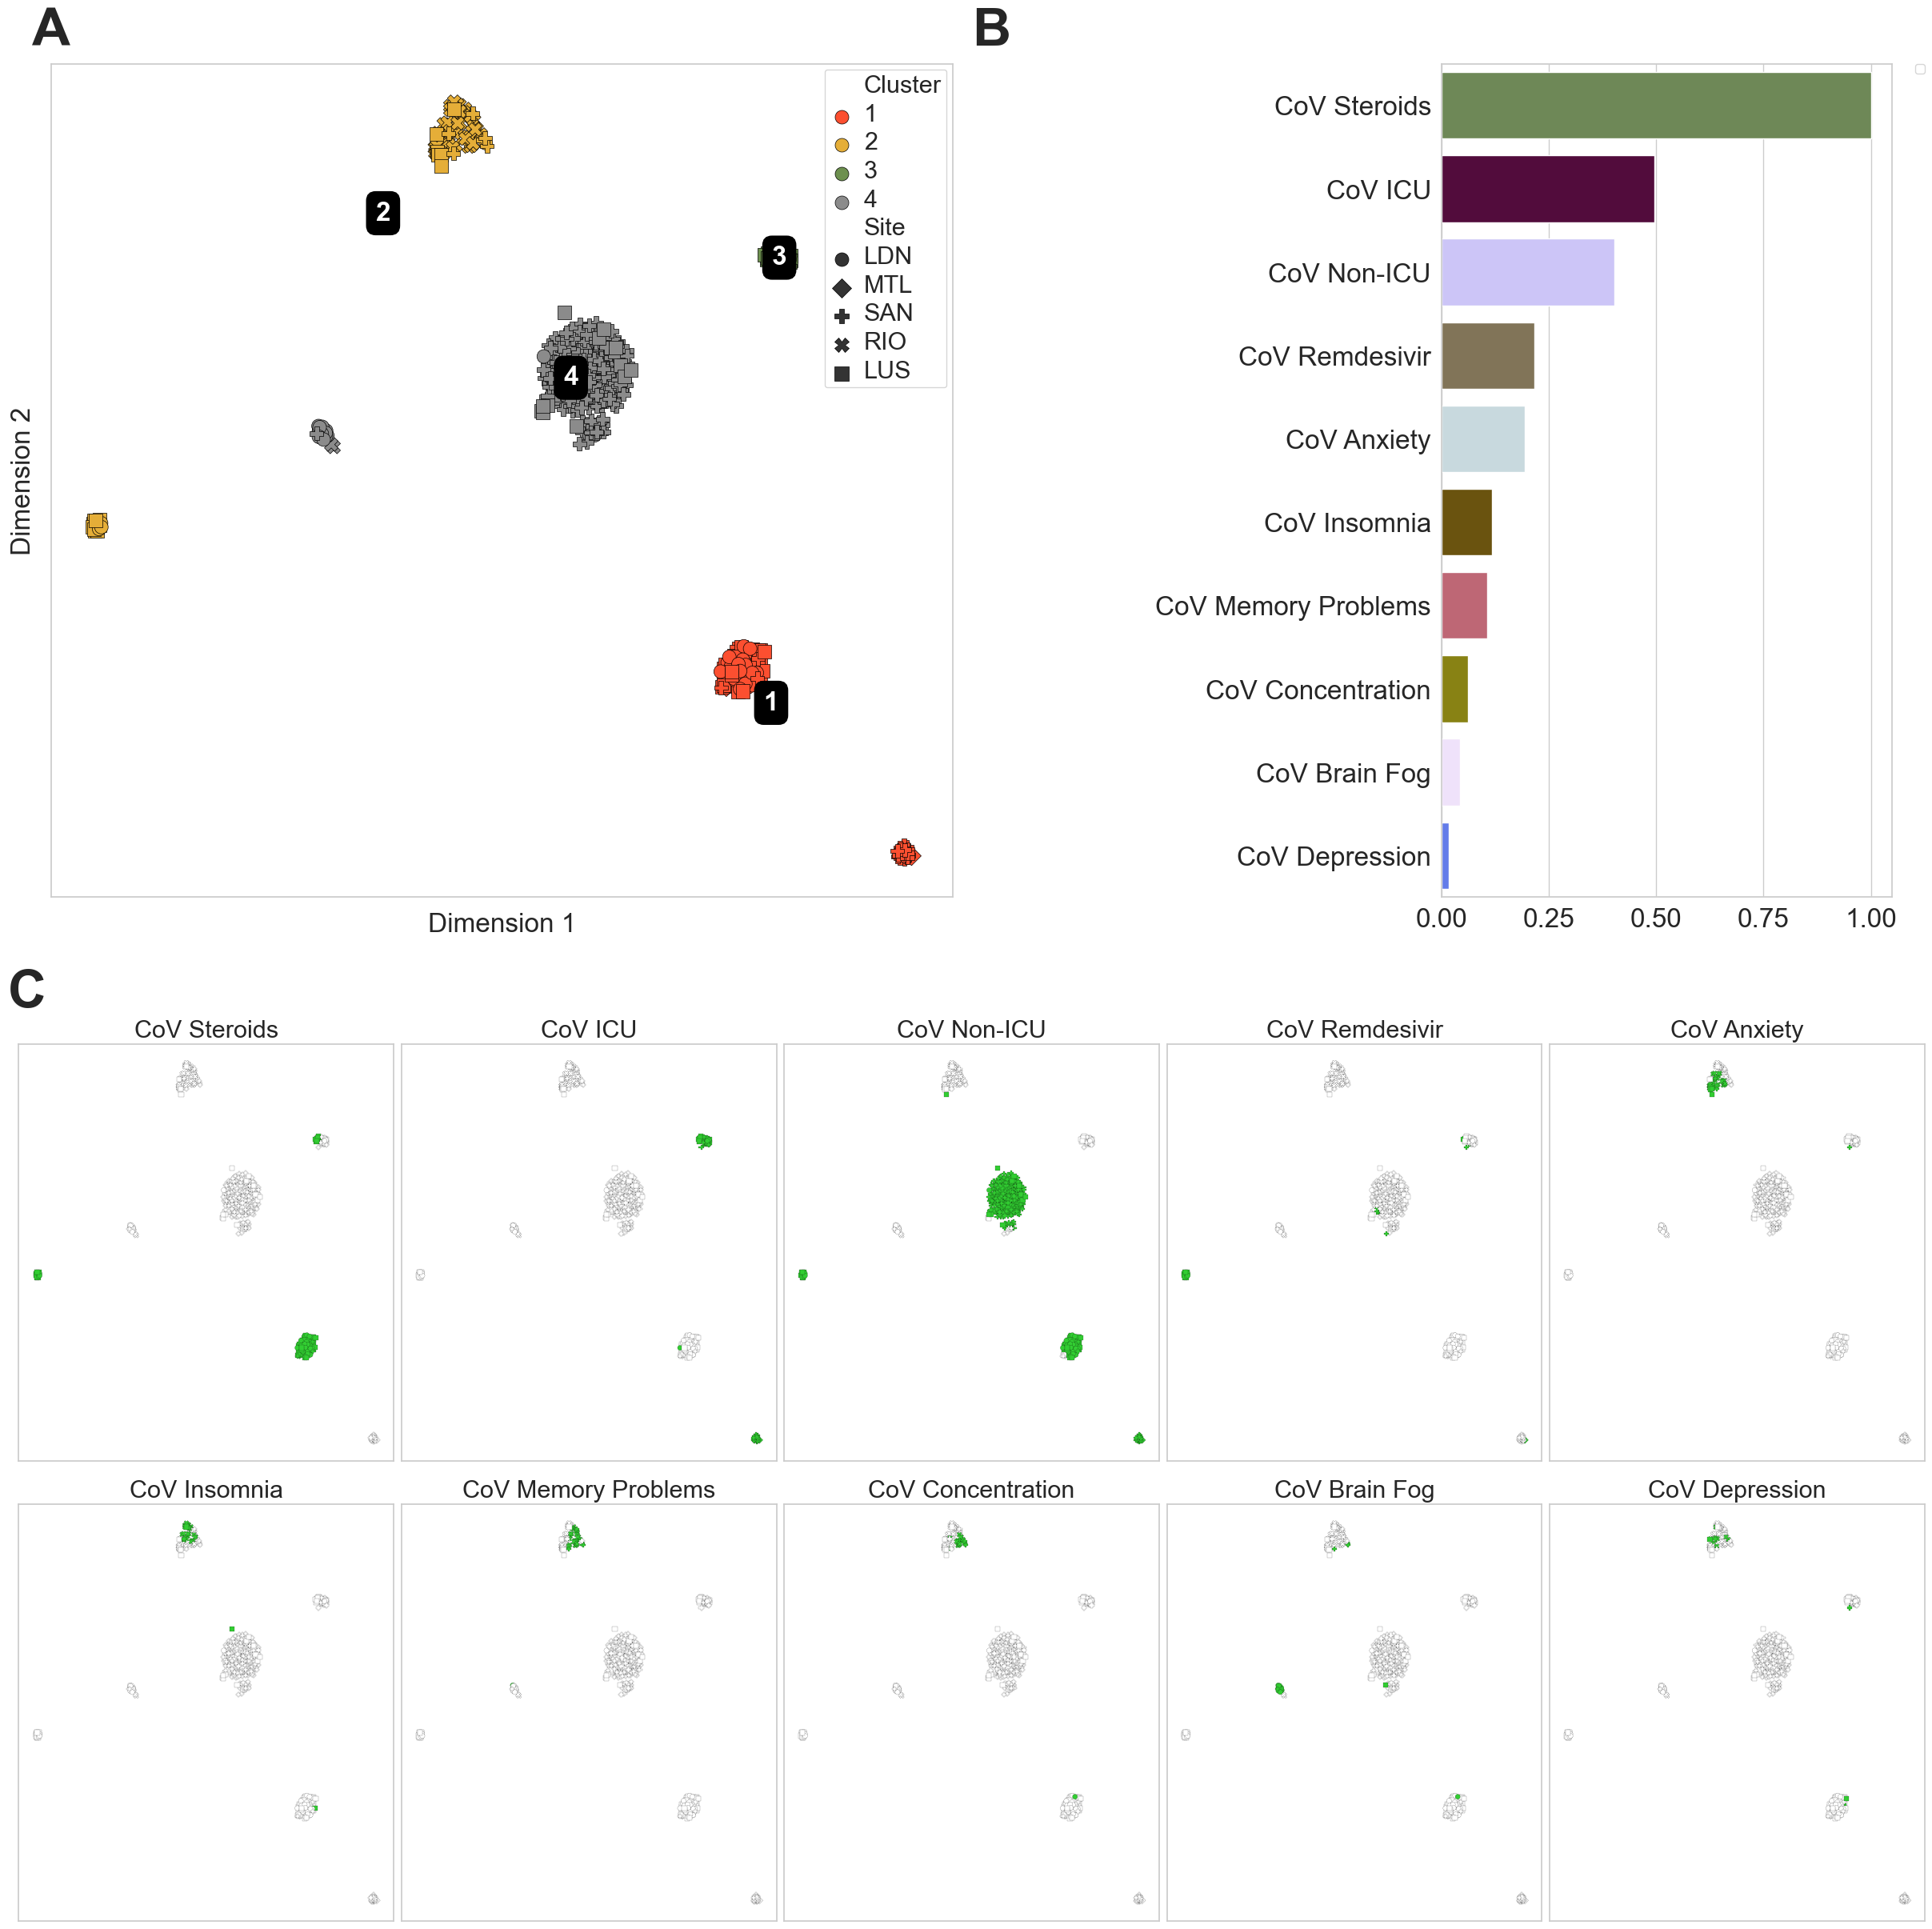

In [379]:
# plot

fig     = plt.figure(layout="constrained", figsize=(24,24))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,1], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(features10, feature_map, feature_colour_map, axs0[1], FONTSIZE)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(2,5)

plot_multiple_features(fi_df[:10], 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    plt.savefig(f"{figdir}/new-worse-only-feature-importances.png", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')